In [1]:
from __future__ import division
import os, warnings, tensorflow as tf
from utils import *

In [2]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Before we begin

This notebook is a preliminary public code repository to the paper "Stateful Detection of Model Extraction Attacks".

Our code base borrows from the following other repositories:

* **StealML** of Tramer _et al._ [1] - [https://github.com/ftramer/Steal-ML/](https://github.com/ftramer/Steal-ML/)
* **ActiveThief** of Pal _et al._ [2] - [https://bitbucket.org/iiscseal/activethief/](https://bitbucket.org/iiscseal/activethief/)

The AdvPD attacks in Papernot _et al._ [3] are reimplemented by us.

The Fashion-MNIST dataset is courtesy Han Xiao _et al._ [4], made available on their [Github repository](https://github.com/zalandoresearch/fashion-mnist) under a MIT License.

### License

The MIT License (MIT) Copyright ©

1. **Fashion MNIST:** [2017] Zalando SE, https://tech.zalando.com

2. **ActiveThief:** 2019 Soham Pal, Yash Gupta, Aditya Shukla, Aditya Kanade, Shirish Shevade, Vinod Ganapathy. Indian Institute of Science.

    THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Load datasets

### Load confidential dataset $\mathcal{D}_C$

In [3]:
from dsl.fashionmnist_dsl import FashionMNISTDSL

In [4]:
train_dsl = FashionMNISTDSL(batch_size = 100, mode='train', normalize_channels=False, shuffle_each_epoch=False, seed=666)
val_dsl   = FashionMNISTDSL(batch_size = 100, mode='val', normalize_channels=False, shuffle_each_epoch=False, seed=666)
test_dsl  = FashionMNISTDSL(batch_size = 100, mode='test', normalize_channels=False, shuffle_each_epoch=False, seed=666)

### Obtain dataset parameters

In [5]:
width, height, channels = train_dsl.get_sample_shape()

is_multilabel = train_dsl.is_multilabel()
num_classes = train_dsl.get_num_classes()
num_batches = train_dsl.get_num_batches()

### Load attacker datasets $\mathcal{D}_A$

Syn-Uniform Retraining (Tramer _et al._ [1])

In [6]:
from dsl.uniform_dsl import UniformDSL

sample_shape = (width, height, channels)
uniform_dsl = UniformDSL(batch_size=100, mode='train', shape=sample_shape, sample_limit=1000, seed=666)

ImageNet samples

In [7]:
from dsl.imagenet_dsl import ImagenetDSL

resize = (width, height)
img_noise_train_dsl = ImagenetDSL(batch_size=100, mode='train', resize=resize, normalize_channels=True, num_to_keep=1000, start_batch=1, end_batch=1, seed=666)

datasets/Imagenet64/train_data_batch_1.npy


## Create models

In [8]:
import tensorflow as tf
from models.deepcnn import DeepCNN
from models.vae import NewHSVNVAE28
from models.defended_model import DefenseModel

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0
TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [9]:
tf.reset_default_graph()

with tf.compat.v1.variable_scope("true_model", reuse=tf.AUTO_REUSE):
    true_model = DeepCNN(
        batch_size=100,
        height=height,
        width=width,
        channels=channels,
        num_classes=num_classes,
        multilabel=is_multilabel,
        is_training=False,
        var_prefix='true_model'
    )

with tf.compat.v1.variable_scope("copy_model"):
    copy_model = DeepCNN(
        batch_size=100,
        height=height,
        width=width,
        channels=channels,
        num_classes=num_classes,
        multilabel=is_multilabel,
        is_training=True,
        var_prefix='copy_model',
        learning_rate=0.001
    )

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Adam Learning rate: 0.001


In [10]:
undefended_saver = tf.train.Saver()

In [11]:
with tf.variable_scope("vae", reuse=tf.AUTO_REUSE):
    vae = NewHSVNVAE28(
        batch_size=100,
        height=height,
        width=width,
        channels=channels,
        is_training=False,
        z_size=32
    )            
    
    defended_model = DefenseModel(
        true_model,
        vae,
        threshold=[0.1, 0.1],
        defender_type="vae_svm",
        use_recon_input=False
    )
    
    oracle_model = defended_model

In [12]:
defended_saver = tf.train.Saver()

## Accuracy of models

In this section, we show the accuracy of defended vs. undefended models on pretrained models for various attackers.

In [13]:
config                          = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement     = False
config.allow_soft_placement     = False

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer()) 

### Syn-Uniform Retraining [1] models

#### Undefended $S_U$ ($\infty$ budget)

In [14]:
logdir_copy = os.path.join('modeldir' , 'tramer', 'undefended')
undefended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/tramer/undefended/model_epoch_49


In [15]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 15.64%


#### VarDefend-Defended $S_D$ ($10,000$ budget)

In [16]:
logdir_copy = os.path.join('modeldir' , 'tramer', 'vae')
defended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/tramer/vae/model_epoch_49


In [17]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 10.06%


### AdvPD-JSMA [3] models

#### Undefended $S_U$ ($\infty$ budget)

In [18]:
logdir_copy = os.path.join('modeldir' , 'jsma', 'undefended')
undefended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/jsma/undefended/model_epoch_99


In [19]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 81.15%


#### VarDefend-Defended $S_D$ ($10,000$ budget)

In [20]:
logdir_copy = os.path.join('modeldir' , 'jsma', 'vae')
defended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/jsma/vae/model_epoch_99


In [21]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 76.65%


### AdvPD-ActiveThief [2] models

#### Undefended $S_U$ ($\infty$ budget)

In [22]:
logdir_copy = os.path.join('modeldir' , 'activethief', 'undefended')
undefended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/activethief/undefended/model_step_720


In [23]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 71.81%


#### VarDefend-Defended $S_D$ ($10,000$ budget)

In [24]:
logdir_copy = os.path.join('modeldir' , 'activethief', 'vae')
defended_saver.restore(sess, tf.train.latest_checkpoint(logdir_copy))

INFO:tensorflow:Restoring parameters from modeldir/activethief/vae/model_step_14


In [25]:
compute_agreement_and_accuracy(true_model, copy_model, sess, test_dsl)

Test Set Accuracy: 10.28%


## Outlier Dataset Generation

Here, we demonstrate the outlier dataset $\mathcal{D}_O$ generation procedure. Samples are shown in the next section.

In [26]:
import copy

In [27]:
outlier_dsl = copy.deepcopy(train_dsl)
num_train_samples = outlier_dsl.data.shape[0]

locs = np.random.uniform(0.0, 1.0, size=num_train_samples)
noise_generated = np.concatenate([[np.random.normal(loc=loc, scale=0.5, size=outlier_dsl.data.shape[1:]) for loc in locs]])
vnoise   = np.random.uniform(low=0.2, high=0.3, size=num_train_samples )
vnoise   = vnoise.reshape(-1, 1, 1, 1)

outlier_dsl.data = np.clip(vnoise * noise_generated + (1-vnoise) * outlier_dsl.data, 0.0, 1.0)

## Load AdvPD samples

In [28]:
advpd_dsl = copy.deepcopy(train_dsl)
advpd_dsl.data = np.load('datasets/AdvPD.npy')

## Dataset Previews

Before we show the representation in latent space, let us take a look at the original dataset samples.

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

### Confidential dataset $\mathcal{D}_C$ samples

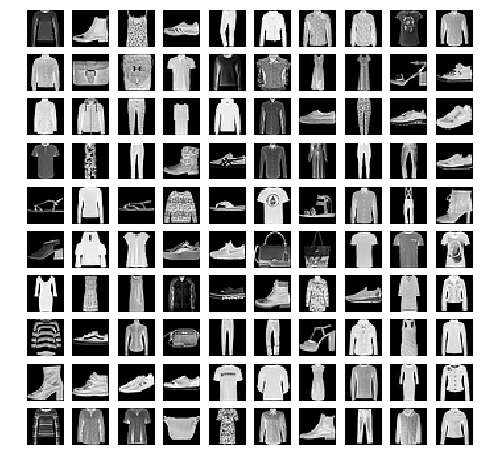

In [30]:
fig = plt.figure(figsize=(8, 8))

for i in range(1, 10 * 10 +1):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(10, 10, i)
    plt.imshow(train_dsl.data[i-1].squeeze(-1), cmap='gray')
    plt.axis('off')

plt.show()

### Outlier dataset $\mathcal{D}_O$ samples

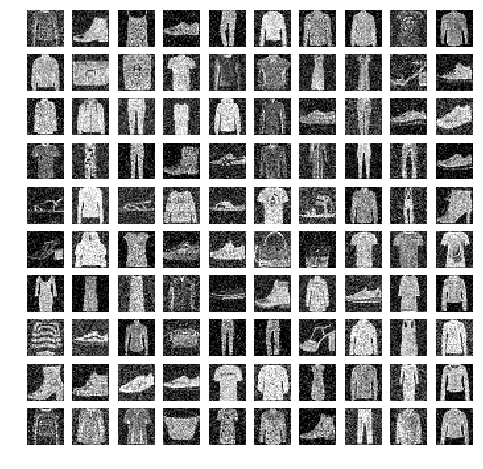

In [31]:
fig = plt.figure(figsize=(8, 8))

for i in range(1, 10 * 10 +1):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(10, 10, i)
    plt.imshow(outlier_dsl.data[i-1].squeeze(-1), cmap='gray')
    plt.axis('off')

plt.show()

### Syn-Uniform Retraining attacker dataset $\mathcal{D}_A$ samples

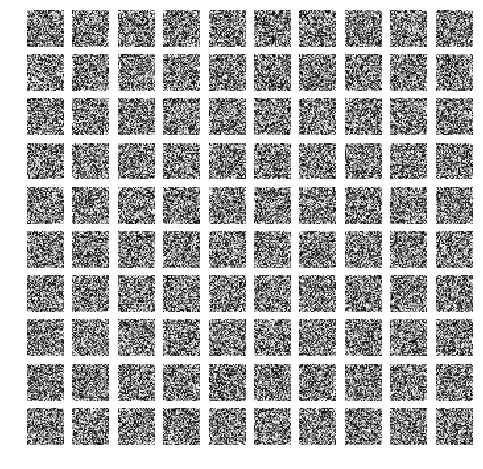

In [32]:
fig = plt.figure(figsize=(8, 8))

for i in range(1, 10 * 10 +1):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(10, 10, i)
    plt.imshow(uniform_dsl.data[i-1].squeeze(-1), cmap='gray')
    plt.axis('off')

plt.show()

### AdvPD-JSMA attacker dataset $\mathcal{D}_A$ samples

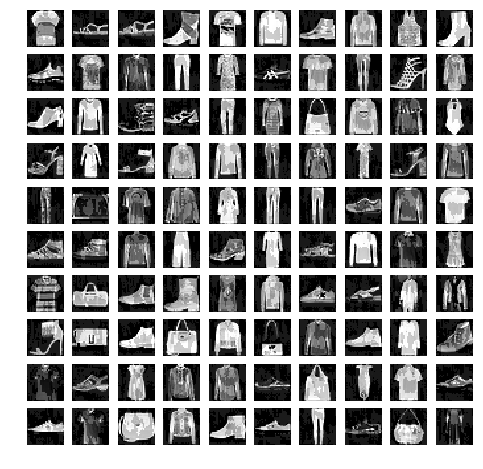

In [33]:
fig = plt.figure(figsize=(8, 8))

for i in range(1, 10 * 10 +1):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(10, 10, i)
    plt.imshow(advpd_dsl.data[150:][i-1].squeeze(-1), cmap='gray')
    plt.axis('off')

plt.show()

### NPD-ActiveThief attacker dataset $\mathcal{D}_A$ samples

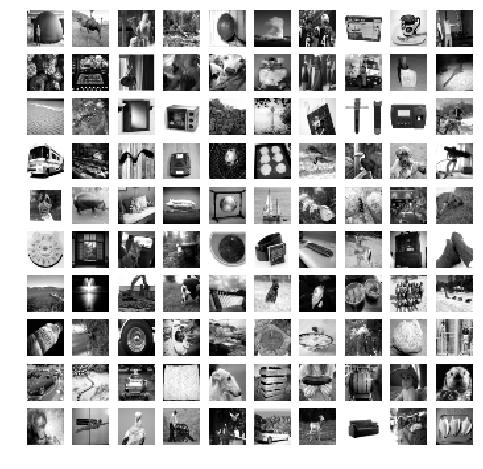

In [34]:
fig = plt.figure(figsize=(8, 8))

for i in range(1, 10 * 10 +1):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(10, 10, i)
    plt.imshow(img_noise_train_dsl.data[i-1].squeeze(-1), cmap='gray')
    plt.axis('off')

plt.show()

## VAE Visualizations

Finally, let us take a look at the latent representations for various datasets.

In [35]:
true_train_zs = sample_z(vae, train_dsl, sess)
outlier_zs    = sample_z(vae, outlier_dsl, sess)
uniform_zs    = sample_z(vae, uniform_dsl, sess)
advpd_zs      = sample_z(vae, advpd_dsl, sess)
img_noise_zs  = sample_z(vae, img_noise_train_dsl, sess)

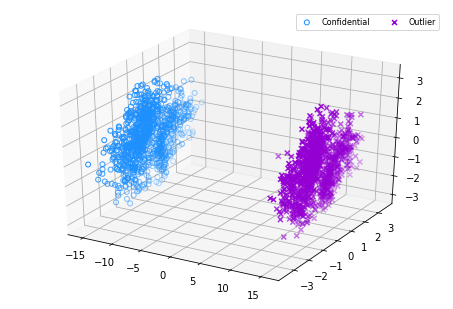

In [36]:
labels  = [ 'Confidential', 'Outlier' ]
plot_pca([true_train_zs, outlier_zs], labels=labels, num_samples=1000, markers=['o', 'x'])

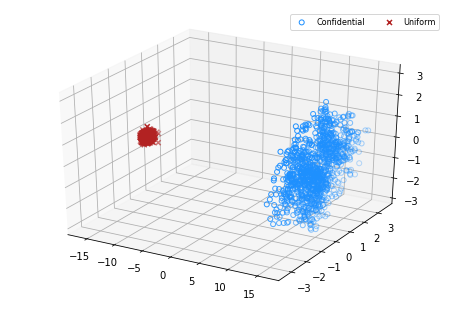

In [37]:
labels  = [ 'Confidential', 'Uniform' ]
plot_pca([true_train_zs, uniform_zs], labels=labels, num_samples=1000, markers=['o', 'x'])

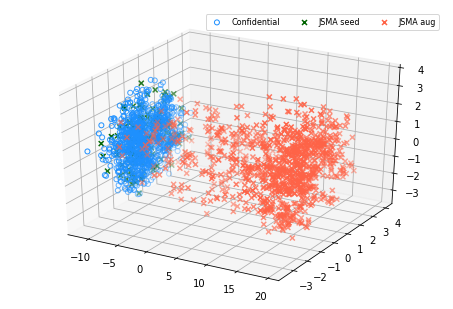

In [38]:
labels  = [ 'Confidential', 'JSMA seed', 'JSMA aug' ]
plot_pca([true_train_zs, advpd_zs[:150], advpd_zs[150:]], labels=labels, num_samples=1000, markers=['o', 'x', 'x'], facecolors=[False, True, True])

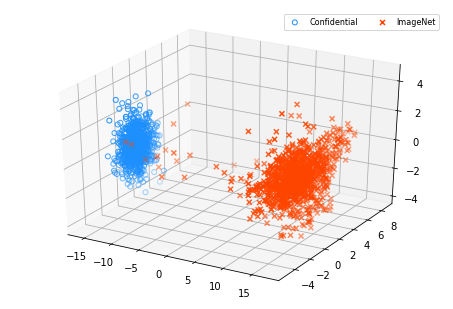

In [39]:
labels  = ['Confidential', 'ImageNet']
plot_pca([true_train_zs, img_noise_zs], labels=labels, num_samples=1000, markers=['o', 'x'])

## References

[1] Tramer, F.; Zhang, F.; Juels, A.; Reiter, M. K.; and Ristenpart, T. 2016.  
Stealing Machine Learning Models via Prediction APIs.  
In _USENIX Security 16_.

[2] Pal, S.; Gupta, Y.; Shukla, A.; Kanade, A.; Shevade, S. K.; and Ganapathy, V. 2020.  
ActiveThief: Model Extraction Using Active Learning and Unannotated Public Data.  
In _Proceedings of the Thirty-Fourth AAAI Conference on Artificial Intelligence, AAAI’20. AAAI Press_.

[3] Papernot, N.; McDaniel, P.; Goodfellow, I.; Jha, S.; Celik, Z. B.; and Swami, A. 2017.  
Practical Black-Box Attacks against Machine Learning.  
In _Proceedings of the 2017 ACM on Asia Conference on Computer and Communications Security, ASIA CCS '17_. ACM.

[4] Xiao, H.; Rasul, K.; and Vollgraf, R. 2017.  
Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms.  
_CoRR_ abs/1708.07747. URL http://arxiv.org/abs/1708.07747.